# MiniProject - Variant 3 - Group M

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

import sklearn
from sklearn.preprocessing import StandardScaler
import time
import mat73 # requires pip install mat73

import pandas as pd
from align import align

## Loading data

<span style="color:orange">**Warning: this will slow down really hard your computer**</span>

In [2]:
n_subject = 1

sub_files = []
emg = []
for i in range(1, n_subject+1):
    sub_files.append(mat73.loadmat('sub/s' + str(i) + '.mat'))
    print("The type of the file nb " + str(i) + " is: " + str(type(sub_files[i-1])))
    print("The keys of the file nb " + str(i) + " are: " + str(sub_files[i-1].keys()))
    print("\n\n")


The type of the file nb 1 is: <class 'dict'>
The keys of the file nb 1 are: dict_keys(['Fs', 'adjusted_class', 'adjusted_label', 'adjusted_repetition', 'class', 'emg_extensors', 'emg_flexors', 'force', 'label', 'outlier_scores_extensors', 'outlier_scores_flexors', 'repetition', 'subject'])





Note for us: They say the signals were captured on 128 channels. From my understanding, its 64 channels on EMG_extensors, and 64 channels on EMG_flexors 

In [3]:
len(sub_files[0]['emg_flexors'].shape[1:])

2

In [9]:

for keys in sub_files[0].keys():
    print("The key '{}' has a shape of '{}'".format(keys, sub_files[0][keys].shape))
    # if len(sub_files[0][keys].shape[1:]) != 2:
    if keys != 'emg_flexors' and keys != 'emg_extensors' and keys!= 'force':
        print("number of uniques: " + str(len(np.unique(sub_files[0][keys]))))
    print("\n\n")

The key 'Fs' has a shape of '()'
number of uniques: 1



The key 'adjusted_class' has a shape of '(6752691,)'
number of uniques: 66



The key 'adjusted_label' has a shape of '(6752691, 16)'
number of uniques: 2



The key 'adjusted_repetition' has a shape of '(6752691,)'
number of uniques: 6



The key 'class' has a shape of '(6752691,)'
number of uniques: 66



The key 'emg_extensors' has a shape of '(6752691, 8, 8)'



The key 'emg_flexors' has a shape of '(6752691, 8, 8)'



The key 'force' has a shape of '(6752691, 9)'



The key 'label' has a shape of '(6752691, 16)'
number of uniques: 2



The key 'outlier_scores_extensors' has a shape of '(8, 8)'
number of uniques: 11



The key 'outlier_scores_flexors' has a shape of '(8, 8)'
number of uniques: 6



The key 'repetition' has a shape of '(6752691,)'
number of uniques: 6



The key 'subject' has a shape of '()'
number of uniques: 1





In [10]:
Fs = sub_files[0]['Fs'][()]
repetition = sub_files[0]['repetition']
adjusted_class = sub_files[0]['adjusted_class']
adjusted_label = sub_files[0]['adjusted_label']
adjusted_repetition = sub_files[0]['adjusted_repetition']

emg_extensors = sub_files[0]['emg_extensors'] 
emg_flexors = sub_files[0]['emg_flexors']
force = sub_files[0]['force'] 
label = sub_files[0]['label']
class_ = sub_files[0]['class']
outlier_scores_extensors = sub_files[0]['outlier_scores_extensors']
outlier_scores_flexors = sub_files[0]['outlier_scores_flexors']
subject = sub_files[0]['subject'][()]

## Part 1

### Preprocessing the data


In [6]:

print(f'What are the shape of the data that we are working with? EMG_extensors: {emg_extensors.shape}, EMG_flexors {emg_flexors.shape}, adjusted_epetition {adjusted_repetition.shape}')

What are the shape of the data that we are working with? EMG_extensors: (6752691, 8, 8), EMG_flexors (6752691, 8, 8), adjusted_epetition (6752691,)


The movement should be the stimuli. We know there are 65 movements + 1 for the resting state, and the only keys to have 66 unique elements are `adjusted_class` and `class`, which correspondonds to the data description in https://www.nature.com/articles/s41597-021-00843-9

<span style="color:orange">check if adjusted_XXX are preprocessed for better correspondance to real movement or not</span>

<span style="color:orange">**WARNING: This will also slow down your computer**</span>

<span style="color:orange">**WARNING: I may be using incorrectly the number of channels**</span>

<span style="color:orange">**WARNING: Maybe we need to remove the outliers, thanks to the corresponding key**</span>


In [11]:
n_repetitions = len(np.unique(adjusted_repetition)) - 1 # -1 because 0 is not a repetition
n_stimuli = len(np.unique(adjusted_class)) - 1 # -1 because 0 is not a repetition
n_channels = emg_extensors.shape[1]*emg_extensors.shape[2]

emg_extensors_reshaped = np.reshape(emg_extensors, (emg_extensors.shape[0], n_channels))
emg_flexors_reshaped = np.reshape(emg_flexors, (emg_flexors.shape[0], n_channels))
print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 65
How many repetitions are there? 5


In [24]:
print(outlier_scores_extensors)

[[0.         0.         0.         0.         0.         0.
  0.         2.0817595 ]
 [0.         0.         0.         0.         0.         0.
  0.         3.50754048]
 [0.         0.         0.         0.         0.         0.
  0.         3.96329969]
 [0.         0.         0.         0.         0.         0.
  0.         3.43826049]
 [0.         0.45246342 0.         0.         0.         0.
  0.         1.59584359]
 [0.         0.         0.         0.         0.         0.
  0.         1.13493122]
 [0.         0.         0.         0.         0.         0.
  0.         1.10279756]
 [0.         0.         0.06995902 0.         0.         0.
  0.         1.91828028]]


### Visualizing the data

In [17]:

number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for i in range(n_stimuli):
    for j in range(n_repetitions):
        
        idx = np.logical_and(adjusted_class == i+1, adjusted_repetition == j+1)
        number_of_samples_per_trial[i, j] = np.sum(idx.astype(int))
        
number_of_samples_per_trial


array([[ 9077.,  9352.,  8961.,  8766.,  8908.],
       [ 9053.,  9404.,  9672.,  9452.,  9089.],
       [ 9392.,  9576.,  9079.,  9311.,  9494.],
       [ 9496.,  9479.,  9439.,  9197.,  9438.],
       [ 9189.,  9493.,  9389.,  9582.,  9124.],
       [ 9626.,  9411.,  9860.,  9982.,  9781.],
       [ 9849., 10663.,  9107.,  9214.,  9603.],
       [ 9760.,  9359.,  9723., 10638.,  9409.],
       [ 9310.,  9167.,  9605.,  9223.,  8963.],
       [10254.,  9489.,  9711., 10011.,  9580.],
       [ 9410., 10024.,  9108., 10500.,  9261.],
       [ 9408.,  9938., 10263.,  9470.,  9110.],
       [ 8885.,  9629.,  9484.,  9465.,  8454.],
       [ 7997.,  9657.,  9083.,  8428., 11516.],
       [ 9563.,  9342.,  9171.,  9410.,  9794.],
       [ 9218., 15412., 10777., 11060.,  9040.],
       [ 8798.,  9234.,  9631.,  9340.,  9701.],
       [10814.,  9102.,  9038.,  8469.,  9120.],
       [11620.,  9476.,  9784., 10052.,  8463.],
       [10859., 17616.,  7513.,  7609.,  9791.],
       [ 9609., 1022

In [18]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for j in range(n_repetitions)] for i in range(n_stimuli)]
emg_rectified = [[None for j in range(n_repetitions)] for i in range(n_stimuli)]
emg_envelopes = [[None for j in range(n_repetitions)] for i in range(n_stimuli)]

for i in range(n_stimuli):
    for j in range(n_repetitions):

        idx = np.logical_and(adjusted_class == i + 1, adjusted_repetition == j + 1).flatten()
        emg_windows[i][j] = emg_extensors_reshaped[idx, :]
        emg_rectified[i][j] = np.abs(emg_windows[i][j])
        emg_envelopes[i][j] = convolve1d(emg_rectified[i][j], mov_mean_weights, axis=0)


Text(0.5, 0.98, 'Windowed EMG signal')

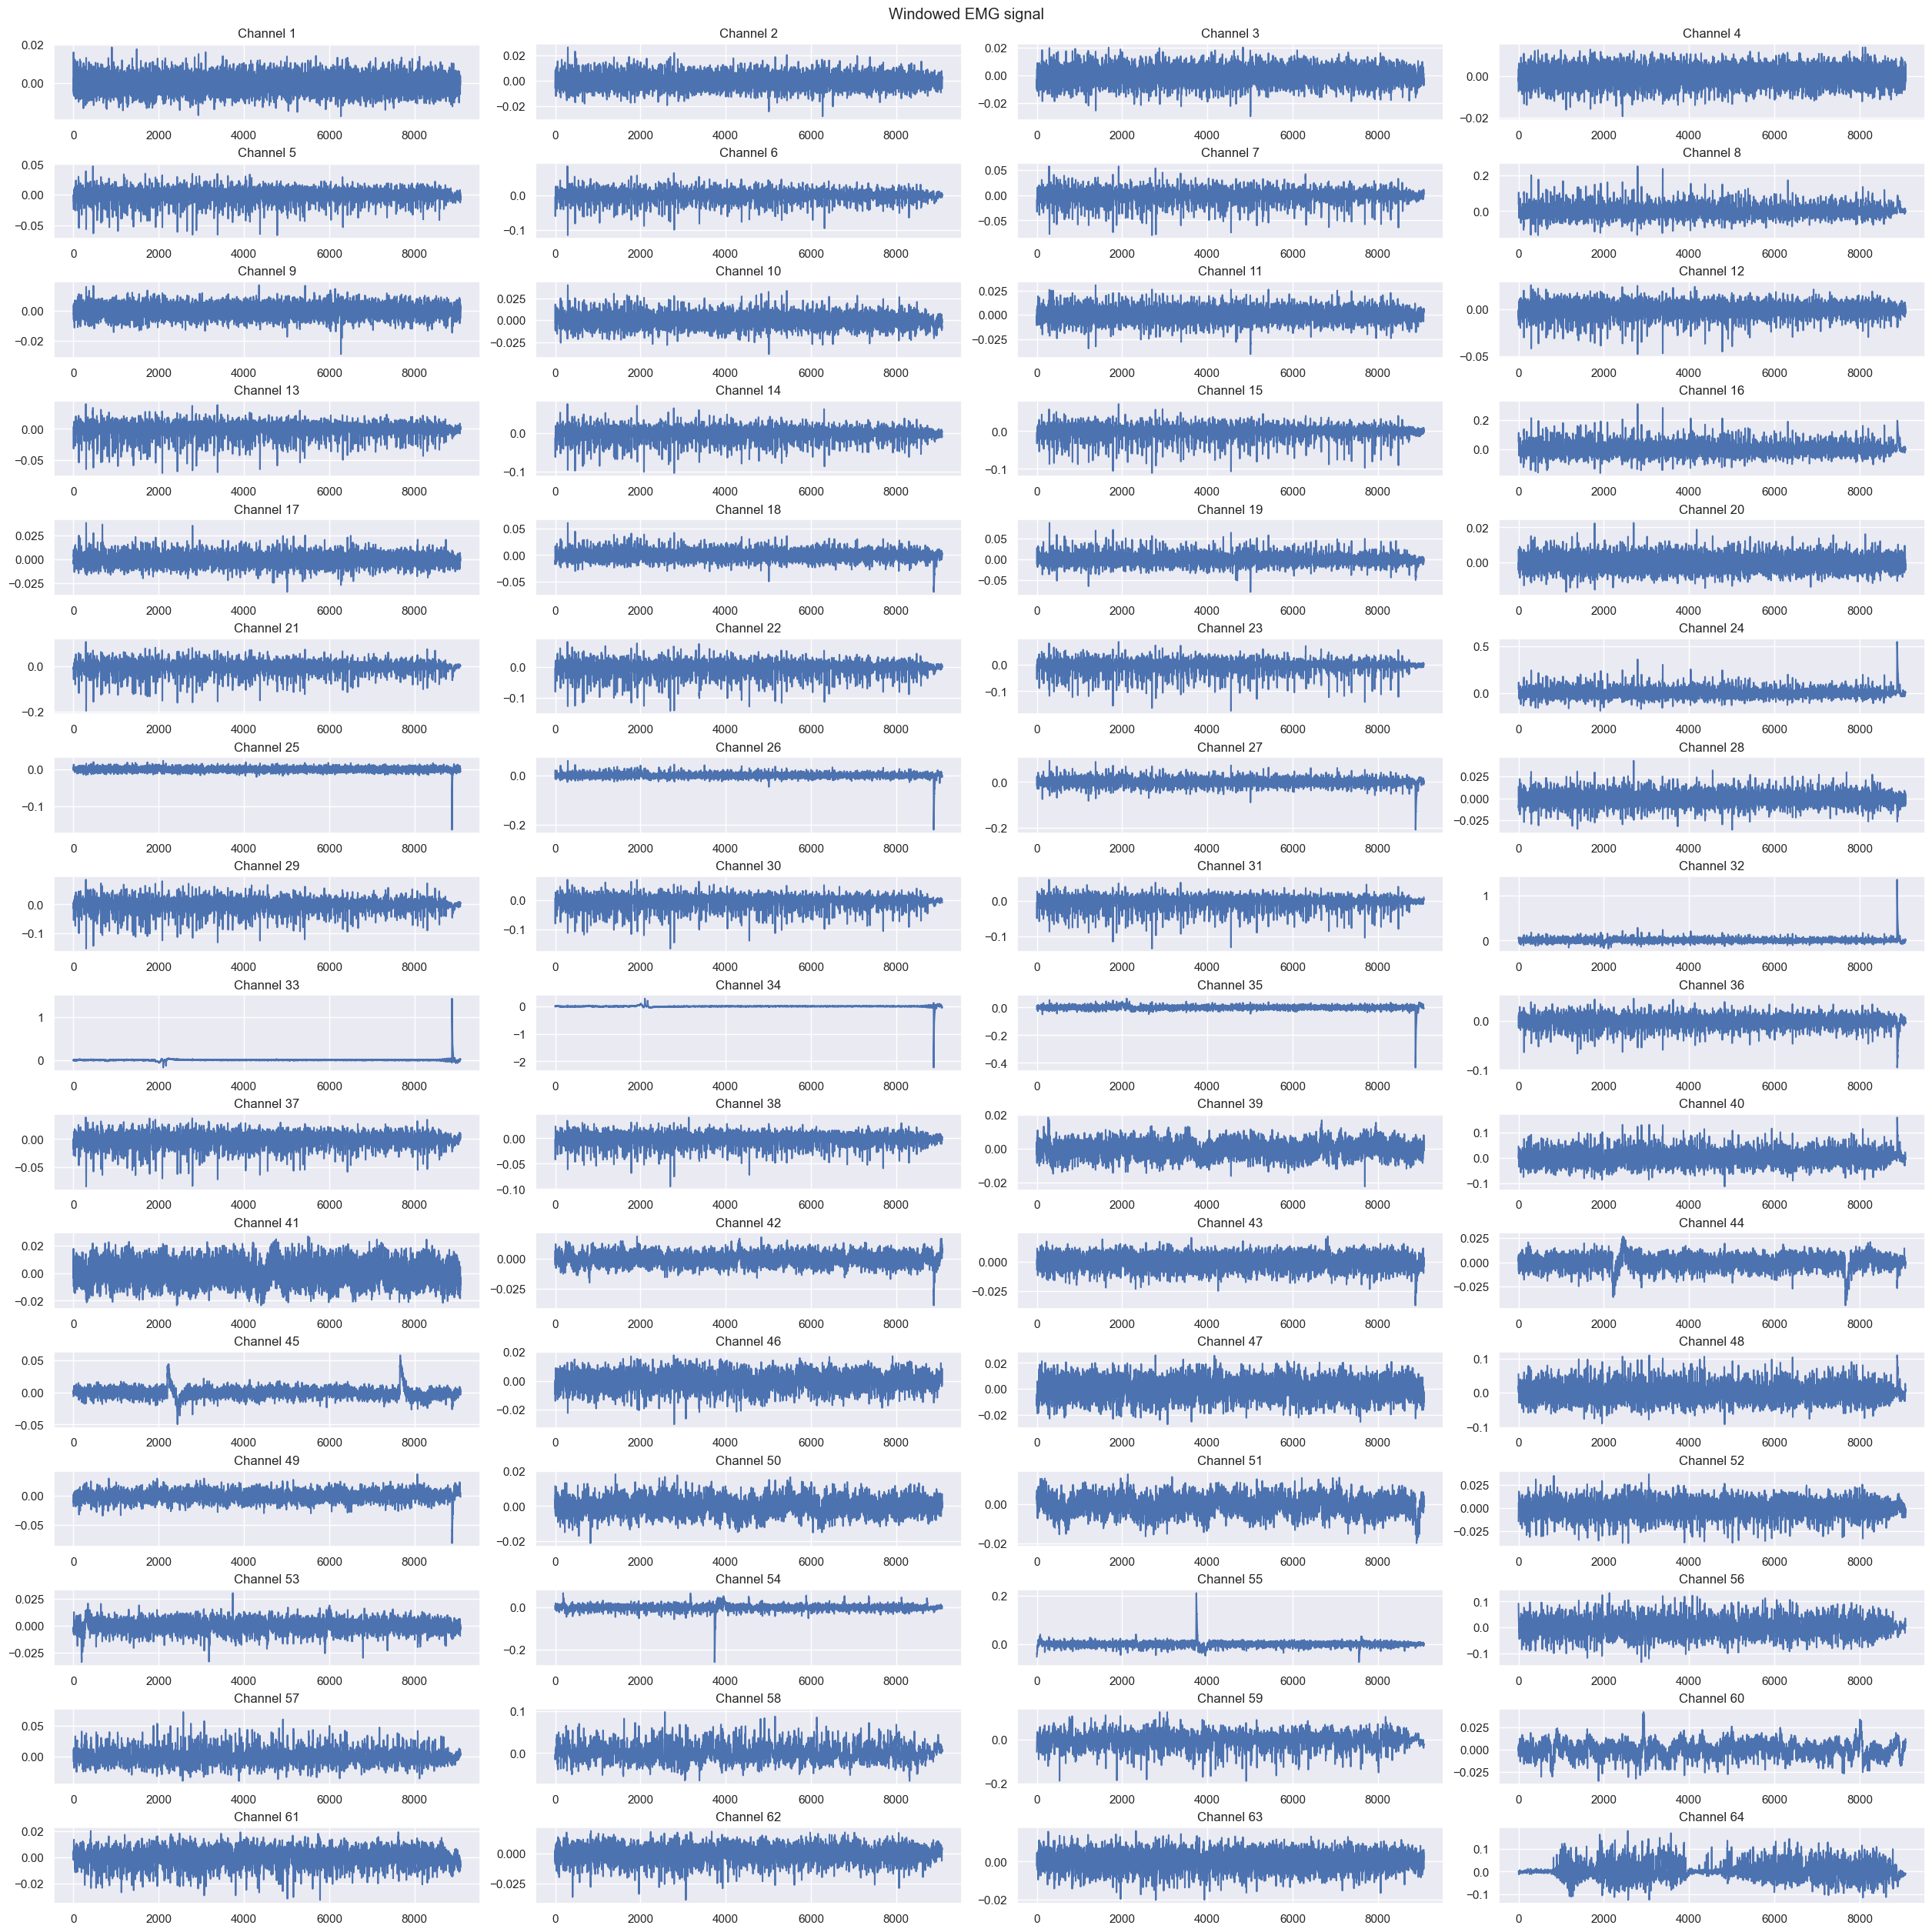

In [20]:

fig, ax = plt.subplots(16, 4, figsize=(25, 25), constrained_layout=True)
ax = ax.ravel()
for i in range(n_channels):
    ax[i].plot(emg_windows[0][0][:, i])
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Windowed EMG signal")

Text(0.5, 0.98, 'Envelopes of the EMG signal')

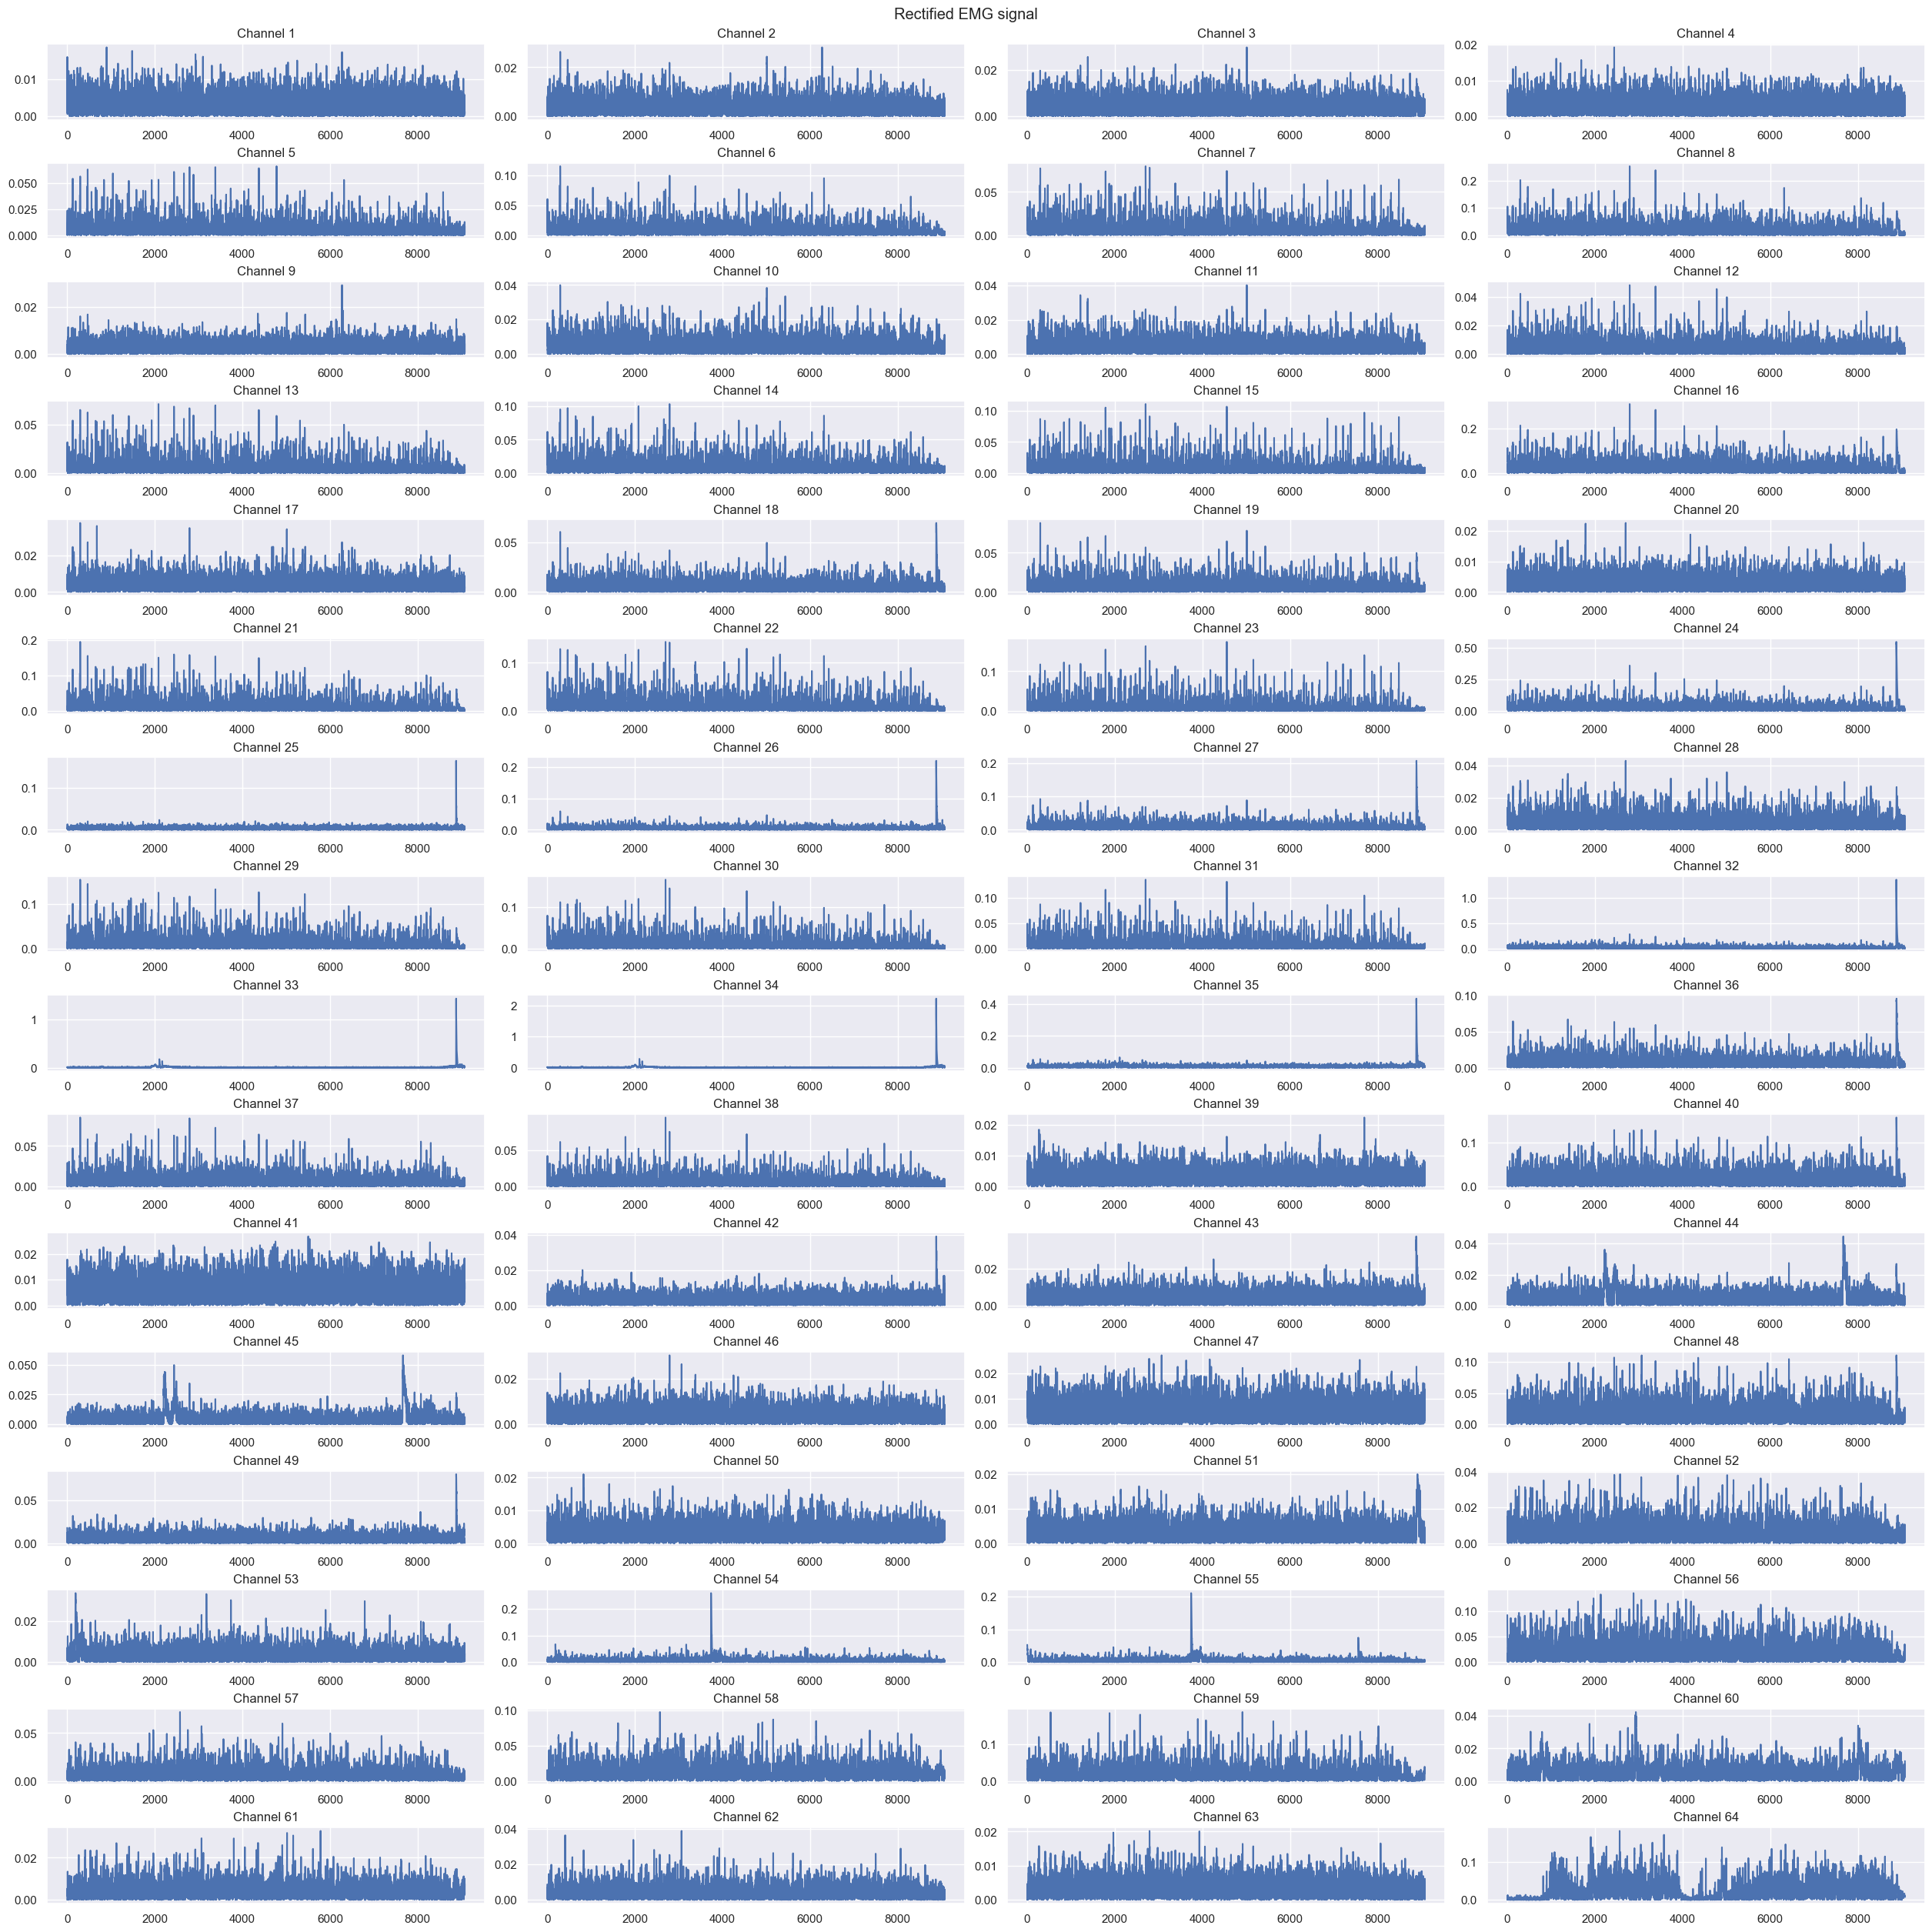

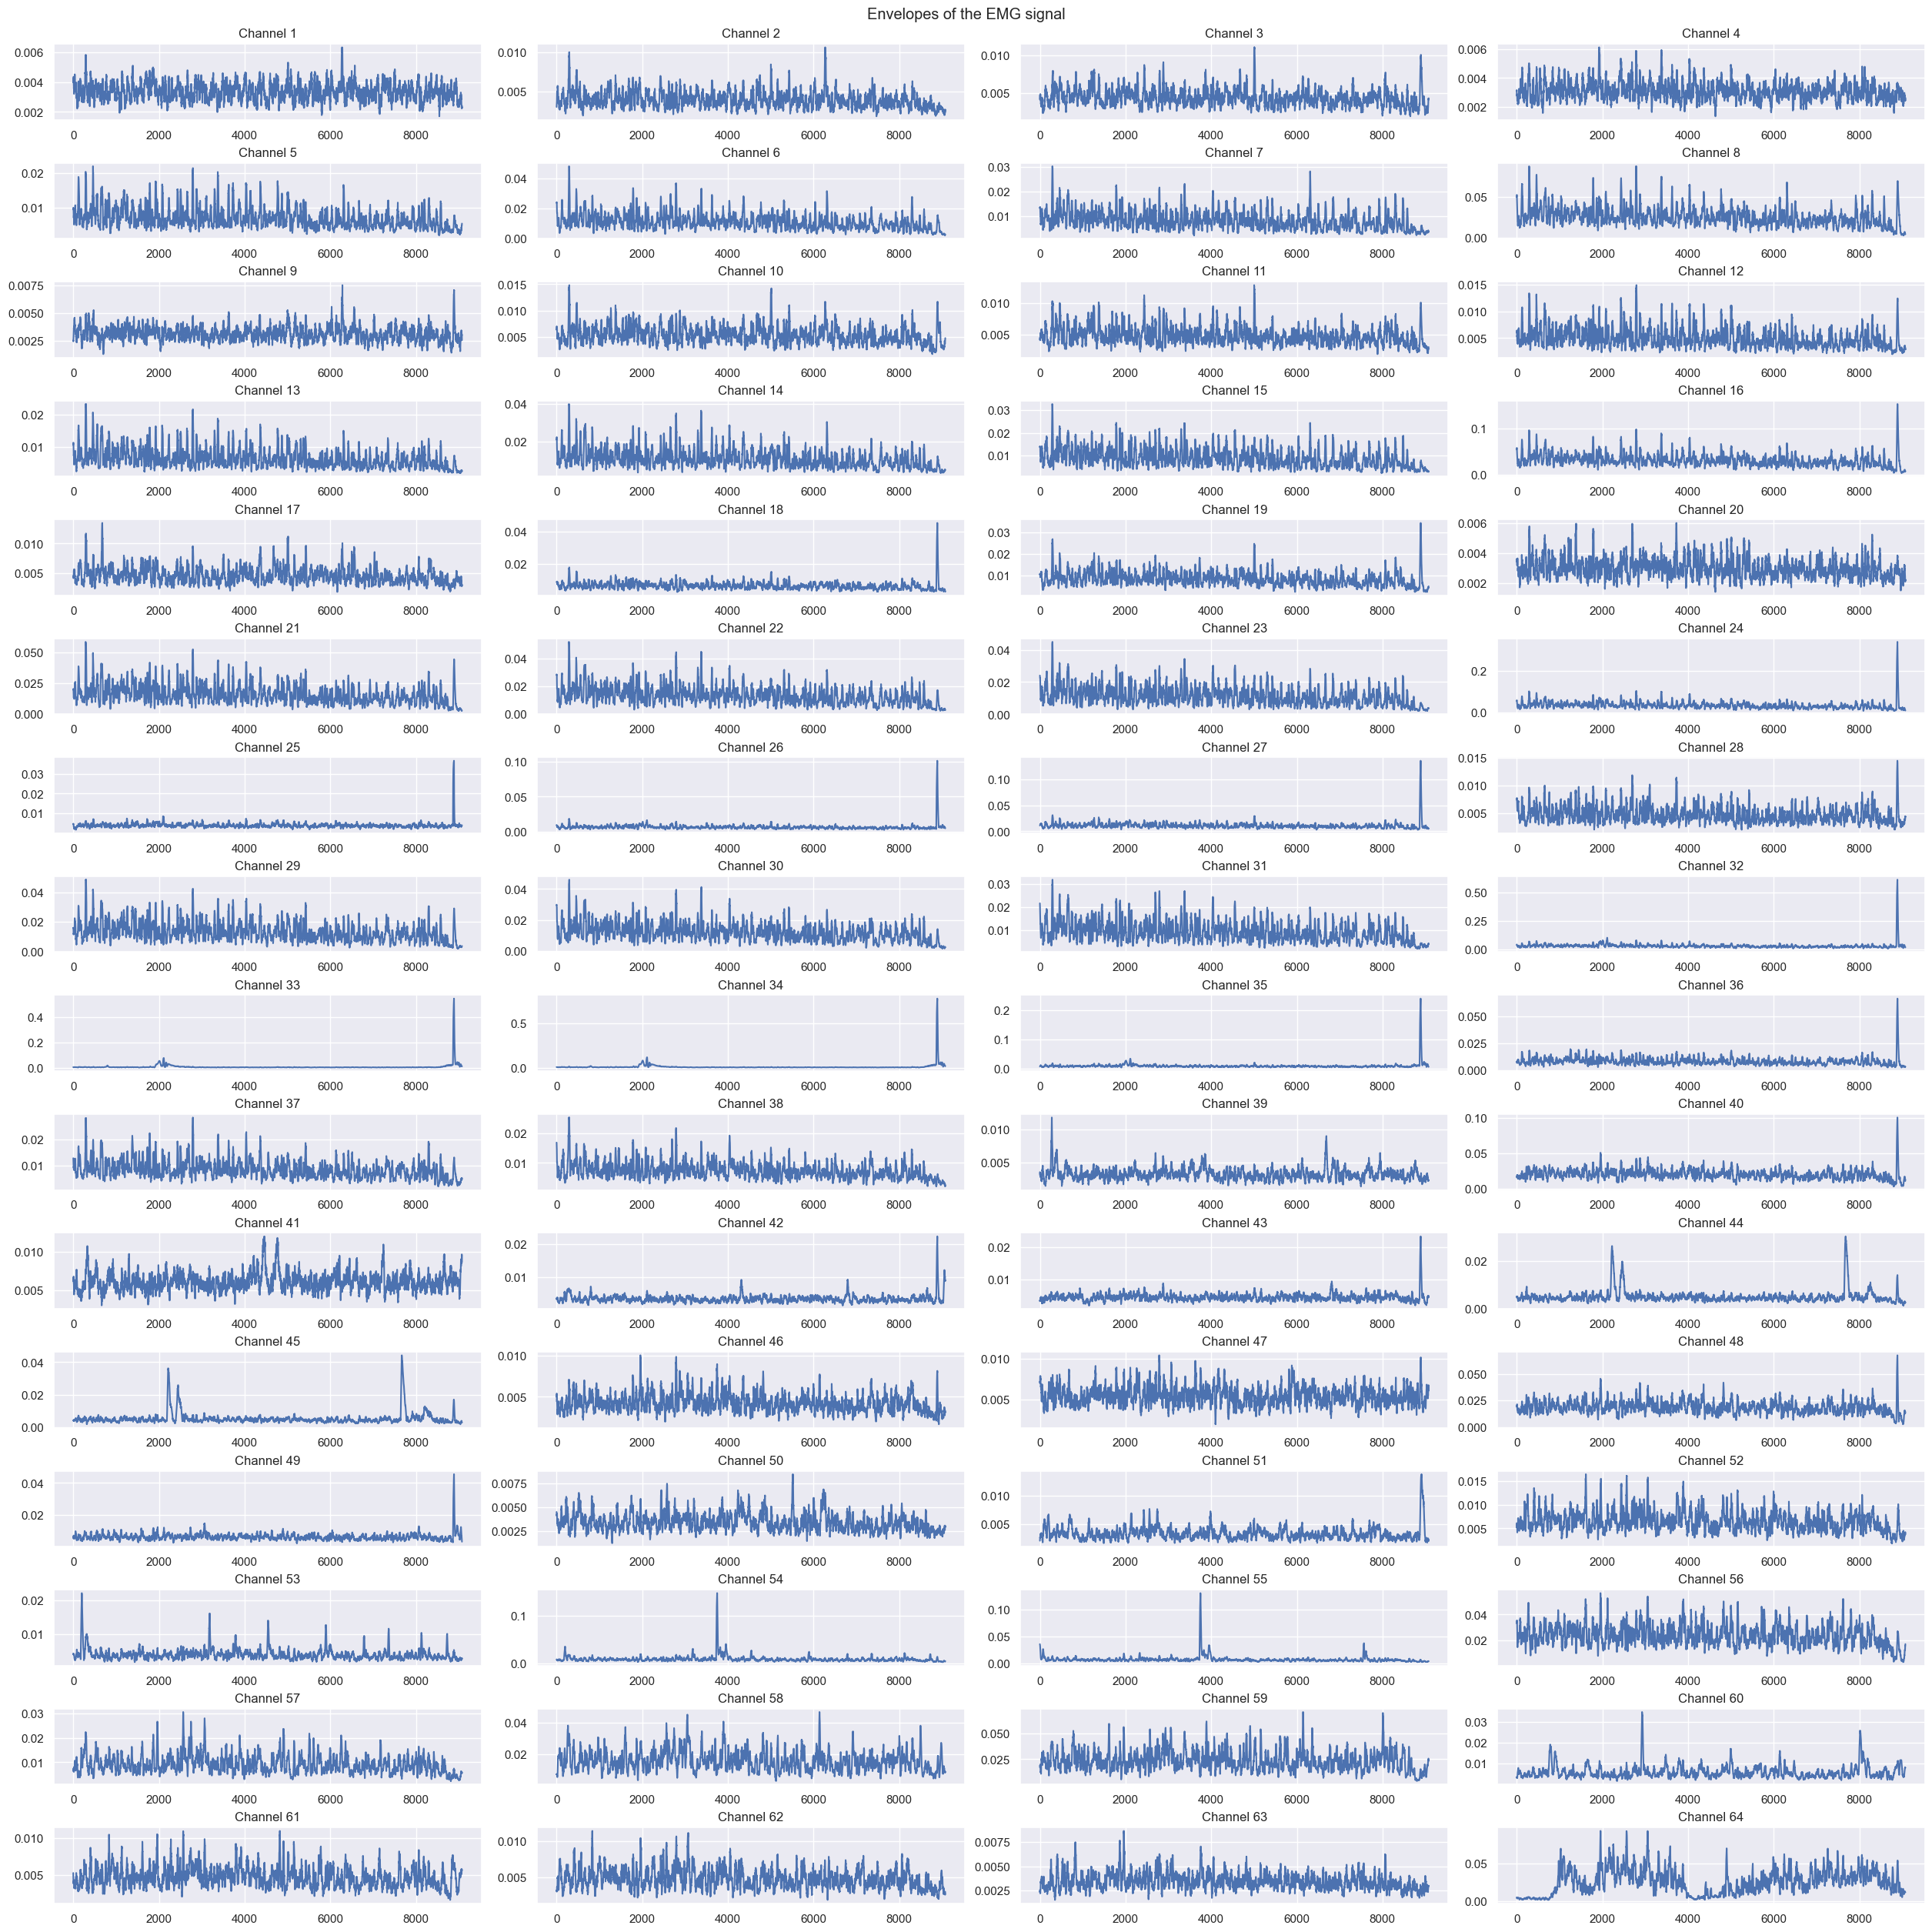

In [23]:
fig, ax = plt.subplots(16, 4, figsize=(25, 25), constrained_layout=True)
ax = ax.ravel()
for i in range(n_channels):
    ax[i].plot(emg_rectified[0][0][:, i])
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Rectified EMG signal")

fig, ax = plt.subplots(16, 4, figsize=(25, 25), constrained_layout=True)
ax = ax.ravel()
for i in range(n_channels):
    ax[i].plot(emg_envelopes[0][0][:, i])
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Envelopes of the EMG signal")

## Part 2

### Spatial synergies using BSS

## Part 3


### Comparison

## Part 4



## Part 5

## Part 6
